# Stochastic Gradient Descent on Linear Regression

#### Table of Contents
* [Introduction](#1)
* [Data Exploration](#2)
* [Dataset Preparation](#3)
* [Data Scaling](#4)
* [Model SGDRegressor](#5)
* [Visualizing the Prediction](#6)
* [Checking Residuals](#7)
* [GridSearchCV](#8)
* [Feature Breakdown](#9)
* [Conclusion](#10)

#### Introduction <a class='anchor' id='1'></a>

In this project, we will use stochastic gradient descent on linear regression to help us figure out the best time to go to the gym to avoid crowds and optimize workout timing.

We will use the "Crowdedness at the Campus Gym' dataset for this analysis.

In summary, we will:

>Load the data into Panda DataFrame

>Clean the data

>Run Exploratory analysis

>Split the data into training and testing set

>Create SGDRegressor and train a SGD linear regression model

>Then, evaluate the model.

In [33]:
#Import libraries
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import math

In [2]:
#Load up the data
gym = pd.read_csv("D:/DataQuest/crowdness_gym_data.csv")

This dataset contains over 60,000 observations about how many people were at the gym on a particular day and time. It contains 11 columns that contain the following information.

>number_people: this is the number of people at the gym at each observation. This will be our target variable or label.

>date: a string value with the specific date and time information.

>timestamp: an integer (int), with the number of seconds since the start of the day (00:00).

>dayofweek: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.

>is_weekend: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.

>is_holiday: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.

>temperature: a float, defining the temperature during the day of the observation in Fahrenheit.

>isstartof_semester: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.

>is_during_semester: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.

>month: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.

>hour: an integer (int) for the hour of the day from 0 to 23.

#### Data Exploration <a class='anchor' id='2'></a>

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


We have no empty rows in our data. Categorical data are in integer format, which is good if we were to use them later. Date is in string format and not datetime format, but we have columns with extracted details already - ie month and hour.

In [4]:
#Let's have a look at how the columns look
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [5]:
gym.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

There are no null values.

In [6]:
corr_matrix = gym.select_dtypes(exclude=['object'])
corr_matrix = corr_matrix.corr()
print(abs(corr_matrix['number_people']).sort_values(ascending=False))

number_people           1.000000
hour                    0.552049
timestamp               0.550218
temperature             0.373327
is_during_semester      0.335350
is_start_of_semester    0.182683
is_weekend              0.173958
day_of_week             0.162062
month                   0.097854
is_holiday              0.048249
Name: number_people, dtype: float64


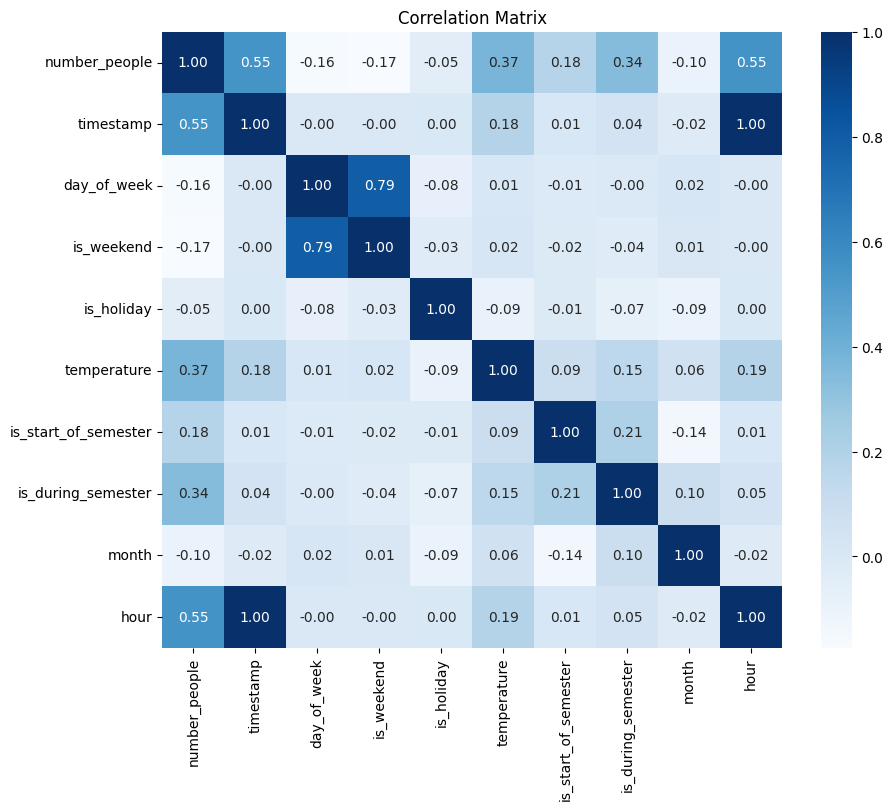

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

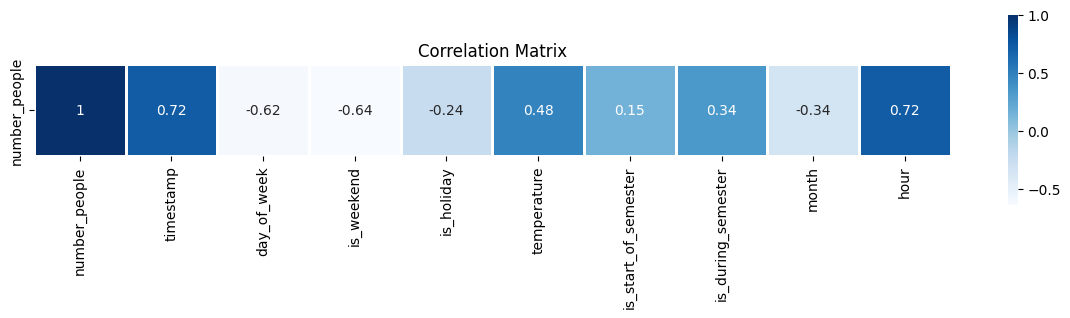

In [8]:
# Show the correlations of number_people specifically
fig, ax = plt.subplots(figsize=(12,3))

sns.heatmap(
    round(corr_matrix.corr(), 2)[corr_matrix.corr().abs() > 0.1].loc[['number_people']],
    cmap='Blues',
    annot=True,
    ax=ax,
    linewidth = 1, 
    square =True,
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Although most of these variables are numeric data, they are numeric representation of categorical data. The heatmap and correlation matrix is not helpful for evaluating whether they are important or not. Temperature (interval data) however does seem to have some correlation so that will be important to keep in our model.

Let's look at frequency graphs for the categorical data to see if there are any interesting trends.

In [9]:
average = gym.groupby('date')['number_people'].mean(0).reset_index()
print(average)

                            date  number_people
0      2015-08-14 17:00:11-07:00           37.0
1      2015-08-14 17:20:14-07:00           45.0
2      2015-08-14 17:30:15-07:00           40.0
3      2015-08-14 17:40:16-07:00           44.0
4      2015-08-14 17:50:17-07:00           45.0
...                          ...            ...
62179  2017-03-18 18:42:28-07:00           23.0
62180  2017-03-18 18:52:35-07:00           21.0
62181  2017-03-18 19:02:40-07:00           25.0
62182  2017-03-18 19:12:47-07:00           18.0
62183  2017-03-18 19:22:51-07:00           23.0

[62184 rows x 2 columns]


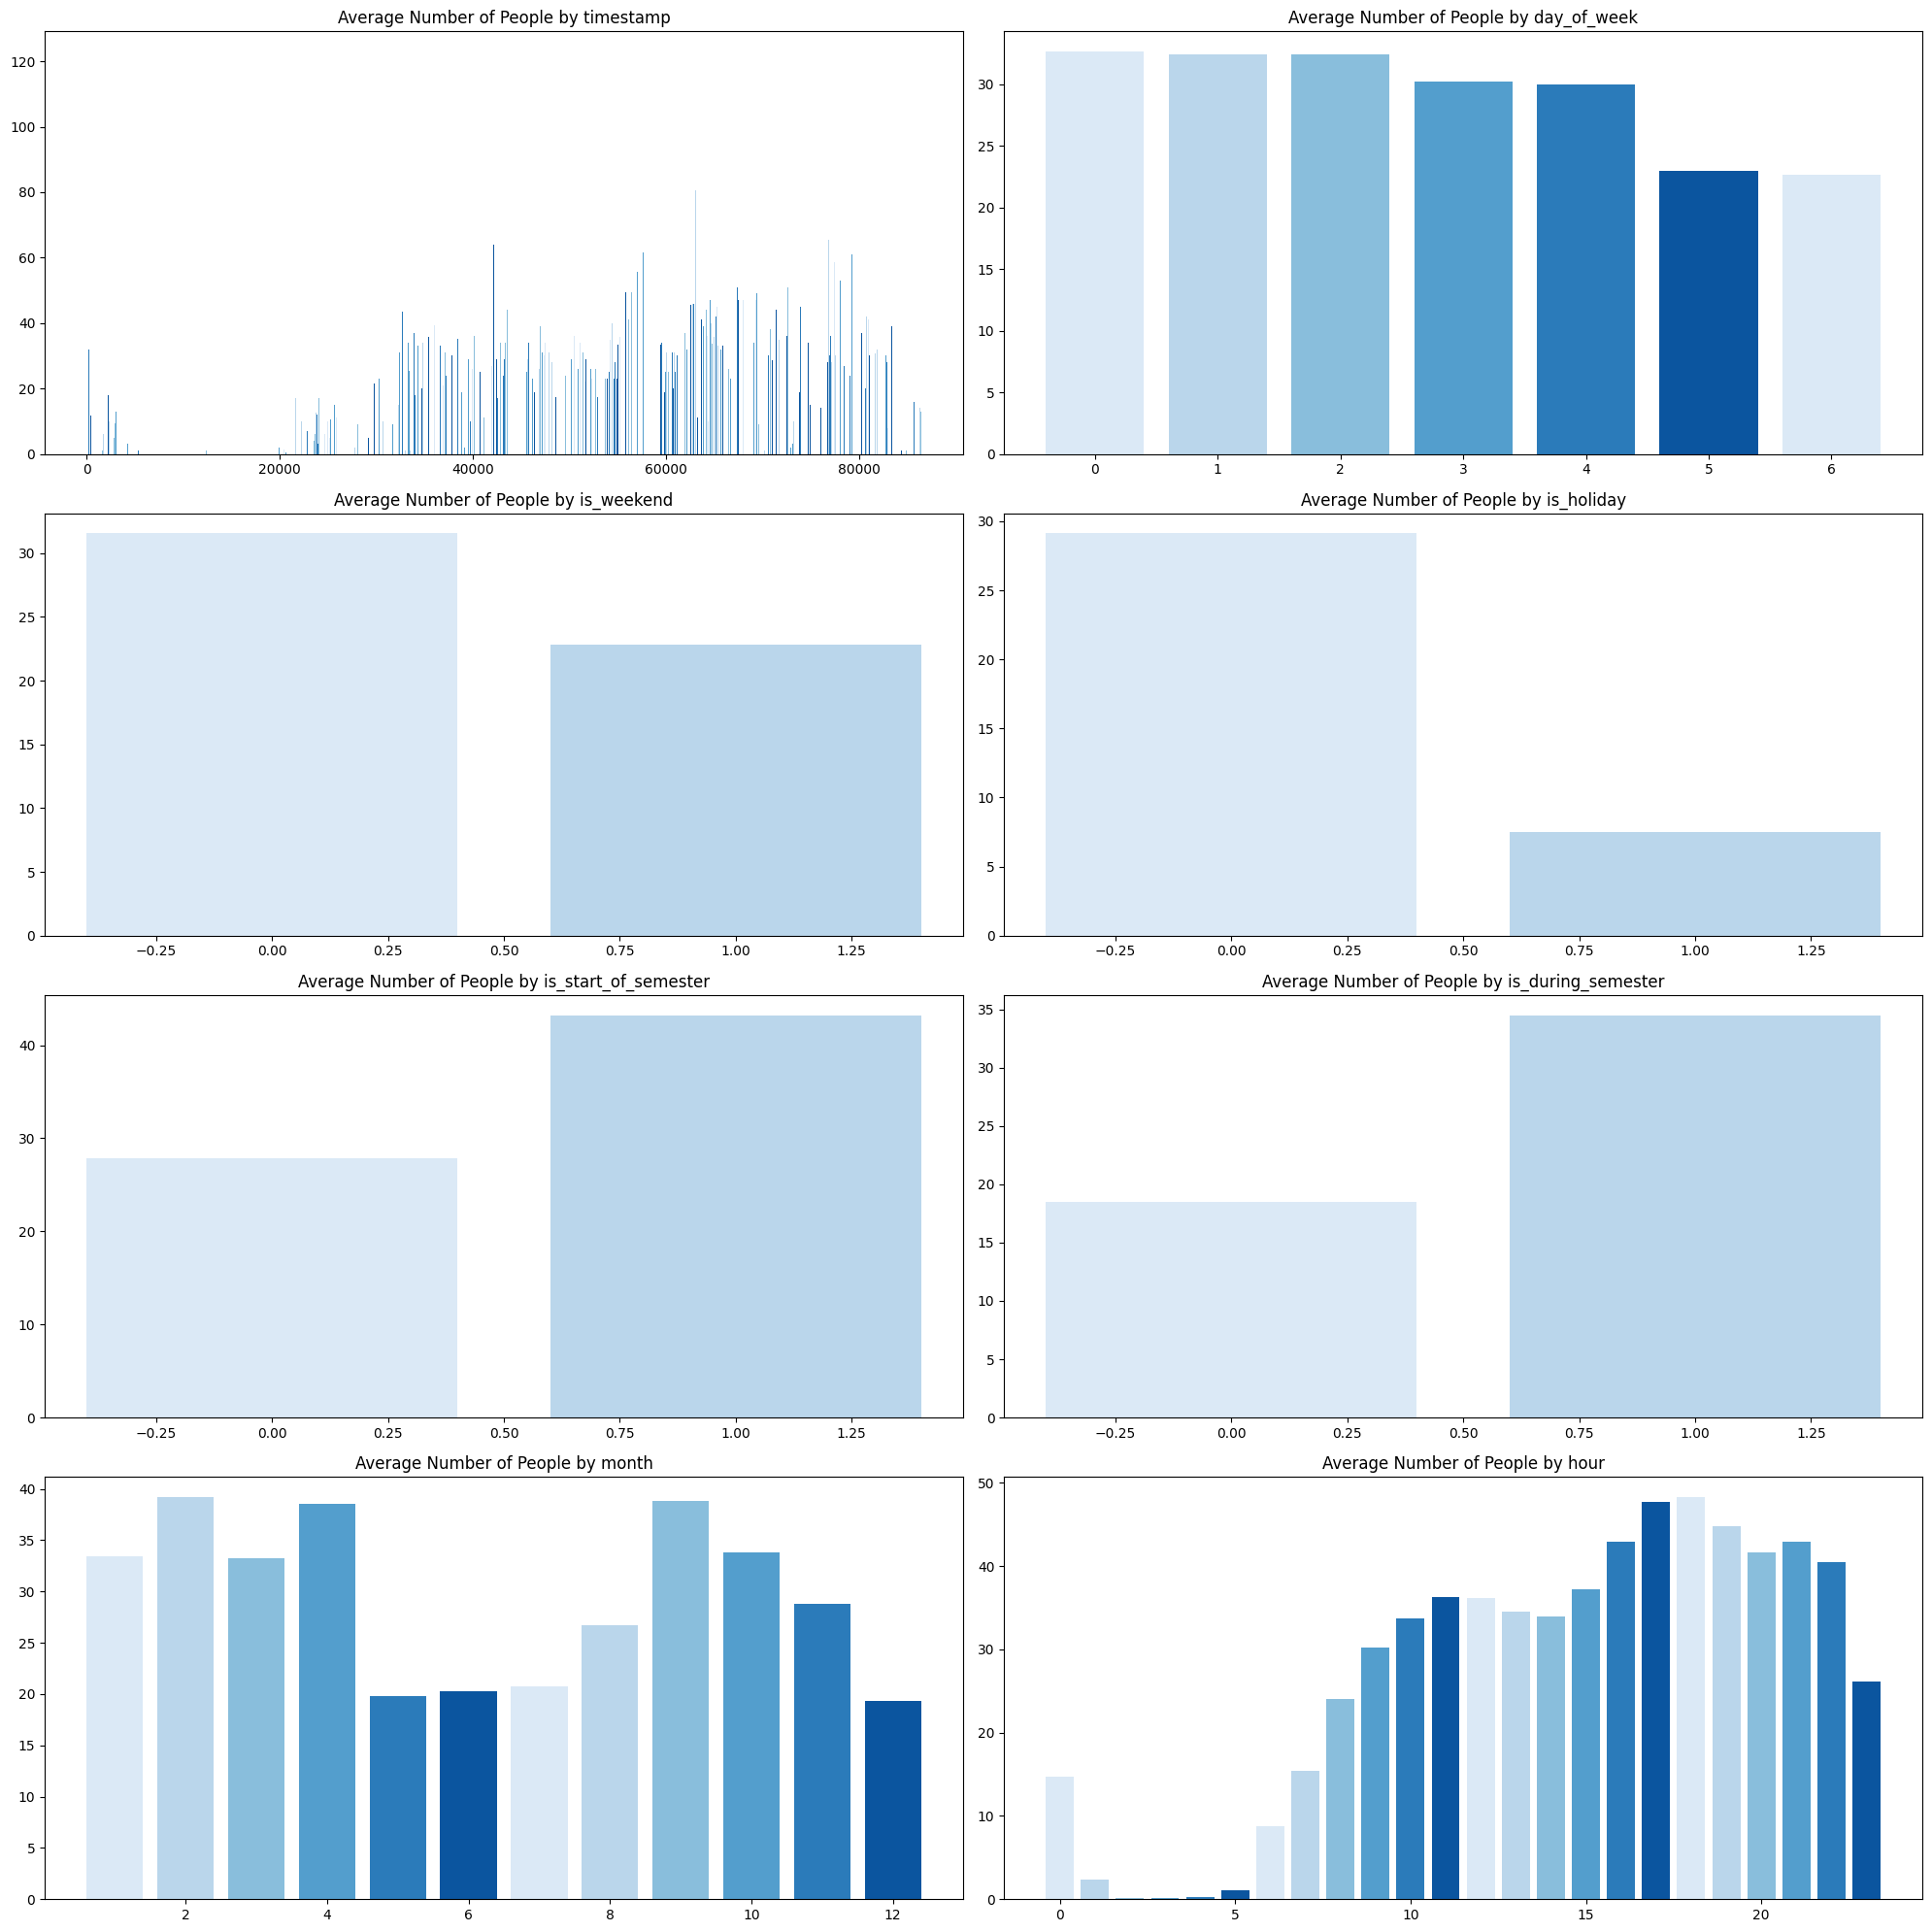

In [53]:
freq = gym.drop('date',axis=1)
freq = freq.drop('temperature',axis=1)
fig = plt.figure(figsize=(20, 20))
for i,x in enumerate(freq):
    if i == 0:
        continue
    else:
        ax = fig.add_subplot(4,2,i)
        average = freq.groupby(x)['number_people'].mean().reset_index()
        ax.bar(x=average.iloc[:,0], height=average.iloc[:,1],color=sns.color_palette('Blues'))
        ax.set_title(f'Average Number of People by {x}')
        ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

Timestamp also provides similar information as hour of the day, so we will remove this too.
Date is not useful and repeated as we already have information with hour, so we will remove this too.
It appears the min-max and range for all the variables appear clean.

In [11]:
#Remove unwanted variables
gym_clean = gym.drop('date', axis=1)
gym_clean = gym_clean.drop('timestamp', axis=1)
gym_clean.columns

Index(['number_people', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')

#### Dataset Preparation <a class='anchor' id='3'></a>

In [12]:
#Split into features and target variable
x = gym_clean.drop('number_people',axis=1)
y = gym_clean['number_people']

In [13]:
#Prepare datasets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=512)

In [14]:
print(X_train.shape)
print(X_test.shape)

(49747, 8)
(12437, 8)


#### Data Scaling <a class='anchor' id='4'></a>

In [15]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Model SGDRegressor <a class='anchor' id='5'></a>

In [16]:
sgdr = SGDRegressor()                # Instantiating the model
sgdr.fit(X_train, y_train)           # Training the model
y_pred = sgdr.predict(X_test) # Making a prediction


In [21]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

MSE: 251.47883313810942
MAE: 12.097542023924495


In [22]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 15.8580841572401


The average number of people is around 20-30. The RMSE is 15, which is quite high. This means that our predicted values can be off by 15 people.

In [23]:
print(f'r2score: {r2_score(y_test, y_pred)}')

r2score: 0.5144577263150798


Correlation is pretty strong at 0.51 (threshold >0.30).

#### Visualizing the Prediction <a class='anchor' id='6'></a>

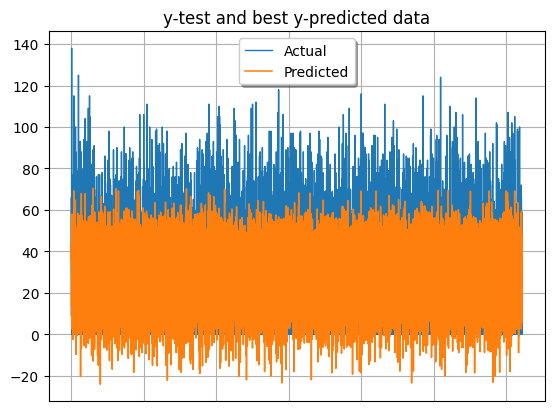

In [20]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="Actual")
plt.plot(x_ax, y_pred, linewidth=1.1, label="Predicted")
plt.title("y-test and best y-predicted data")
plt.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are offplt.ylabel('People in gym')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

From the graph we can see that our model tends to underpredict the number of people.

#### Checking Residuals <a class='anchor' id='7'></a>

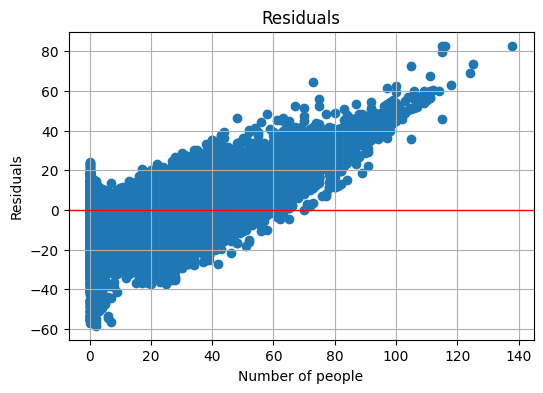

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals)
plt.xlabel('Number of people')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.grid(True)
plt.show()

The residuals are not banded around 0, so this is not a good sign for our model. Our model tends to have higher error in prediction as the number of people increases.

#### GridSearchCV <a class='anchor' id='8'></a>

Let's use gridsearch to help us optimize our hyperparameters.

In [28]:
sgdr = SGDRegressor()
param_grid = {
    'loss': ['squared_error','huber','epsilon_insensitive'],
    'penalty': ['l2','l1','elasticnet'],
    'learning_rate': ['constant', 'adaptive', 'optimal'],
    'eta0': [0.1, 0.01],
    'tol': [0.1, 0.001]
}

# Let's optimise for the R-squared number
grid_search = GridSearchCV(estimator=sgdr, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f'The best parameters are {best_params}')
print(f'The best estimator is {best_estimator}\n')

best_estimator.fit(X_train, y_train)

# Make a prediction
y_pred = best_estimator.predict(X_test)

# Check model
mse = mean_squared_error(y_test, y_pred)
print('mse:',mse)

mae = mean_absolute_error(y_test, y_pred)
print('mae:',mae)

r2s = r2_score(y_test, y_pred)
print('r2s:',r2s)

The best parameters are {'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_error', 'penalty': 'l1', 'tol': 0.1}
The best estimator is SGDRegressor(eta0=0.1, learning_rate='adaptive', penalty='l1', tol=0.1)

mse: 251.23660777036292
mae: 12.092169383849573
r2s: 0.514925402478247


Looks like there isn't much improvement.

Previous model:

MSE: 251.47883313810942

MAE: 12.097542023924495

r2score: 0.5144577263150798

Let's keep to our original model and have a look at what could possibly be the issue with our model.

#### Feature Breakdown <a class='anchor' id='9'></a>

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=512)
#Let's put our y_test and y_pred into a single dataframe
gym_test = X_test
gym_test['number_people'] = y_test
gym_test['pred_num_people'] = y_pred
gym_test['temperature_rounded'] = round(gym_test['temperature'])
gym_test.head()

,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,number_people,pred_num_people,temperature_rounded
34003,1,0,0,56.95,0,0,7,7,9,13.720167,57.0
8486,0,0,0,54.63,0,1,11,20,66,43.602688,55.0
34197,2,0,0,58.00,0,0,7,15,25,26.977839,58.0
24628,6,1,0,55.31,0,1,4,22,42,42.242512,55.0
61523,6,1,0,54.90,0,1,3,18,31,36.049247,55.0


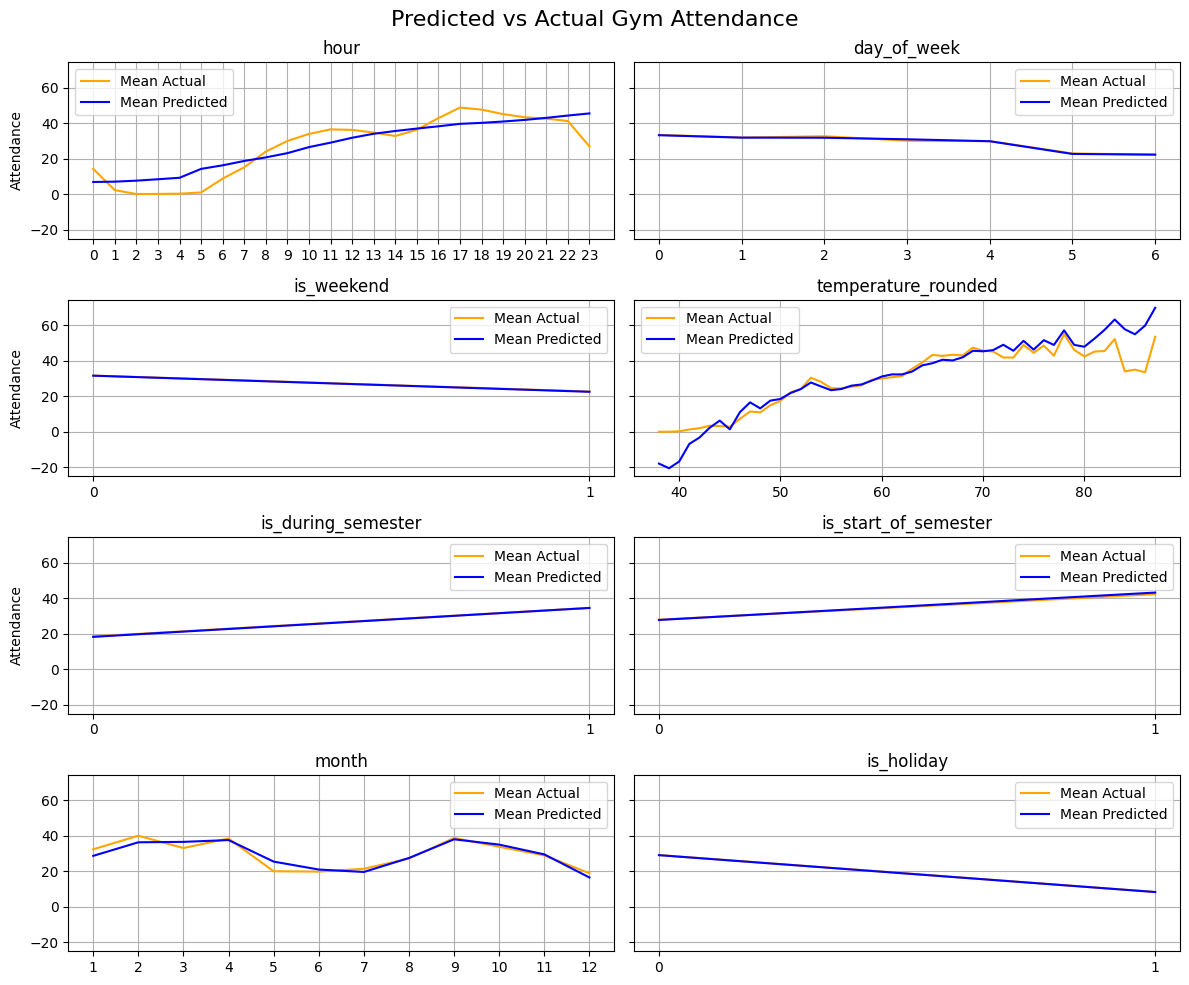

In [51]:
columns_to_plot = ['hour', 'day_of_week', 'is_weekend', 'temperature_rounded', 'is_during_semester', 'is_start_of_semester','month','is_holiday']

fig, axs = plt.subplots(4, 2, tight_layout=True, sharey=True, figsize=(12, 10))

fig.suptitle('Predicted vs Actual Gym Attendance',fontsize=16)

for index, column in enumerate(columns_to_plot):
    ax_row = math.floor(index / 2)
    ax_column = index % 2

    # show the mean number of actual people for each value.
    axs[ax_row][ax_column].plot(sorted(gym_test[column].unique()), gym_test.groupby(column)['number_people'].mean(), color='Orange',label='Mean Actual')
    # show the mean number of predicted people for each value.
    axs[ax_row][ax_column].plot(sorted(gym_test[column].unique()), gym_test.groupby(column)['pred_num_people'].mean(), color='Blue',label='Mean Predicted')
    axs[ax_row][ax_column].set_title(column)
    axs[ax_row][ax_column].legend()    
    if len(gym_test[column].unique()) <= 24:
        axs[ax_row][ax_column].set_xticks(gym_test[column].unique())
    axs[ax_row][ax_column].grid(True)
    
for i in range(3):
    axs[i][0].set_ylabel('Attendance')

plt.show()

Hour and temperature contribute the most to the error in our model prediction whereas the rest of the features follow the linear model. However, note from our analysis previously that hour and temperature have the highest correlation with number of peope compared to the rest of the features.

#### Conclusion <a class='anchor' id='10'></a>

Our ML model was unable to predict with good accuracy the actual number of people going to the gym. In fact, our model tends to underpredict with mean absolute error about 12 - so about 12 people. Depending on the size of your gym, this may or may not be a huge issue. 

We are, however, able to make predictions on when is the best time to go to the gym (without need for ML in this case). The best times for a gym session have the following characteristics:

>Early in the morning from 12am to 8am

>When the weather is cold 40-50F

>During the holidays

>During the months May to July